## Patch Generation

These scripts generate the patches used to build our later models. The patches represent the data that is fed into the models.

There are several basic functions we need.

1. Create bounding boxes around a contour such that it perfectly fits matches the patch size desired. Thus for a patch_size of 64 our bounding box sizes should be multiples of 64 in both the height and width dimensions. The same applies for all other patch_sizes.

2. Create patches which overlap one another by $0.5 \cdot patchSize$ within the bounding box region.

3. Allow flexible removal of patches which do not intersect the polygon ROI within the bounding box. (The default will be to remove all which overlap by less that 50%).  

3. Ensure that the position of the patch is saved so we can render it later on top of the image. i.e. save the top left corner (x,y) pixel pair.

4. Label each patch that is generated.

5. Save patch information to a csv file (contains: pixel pair, patch_image_name, generated_patch_id) and save the patch_image to the file system. 

In [4]:
# load libraries
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import pandas as pd
import os

from pylab import rcParams
rcParams['figure.figsize'] = (10,6)

# setup data links
folder_id = '38caa6a4'
base_dir = os.path.join('./data', folder_id)
base_image_dir = os.path.join(base_dir, 'images')
base_contours_dir = os.path.join(base_dir, 'contours')

train_images_csv   = os.path.join(base_dir, 'train_images.csv')
train_contours_csv = os.path.join(base_dir, 'train_contours.csv')
test_images_csv    = os.path.join(base_dir, 'test_images.csv')
test_contours_csv  = os.path.join(base_dir, 'test_contours.csv')

train_images_d   = pd.read_csv(train_images_csv, index_col=0)
train_contours_d = pd.read_csv(train_contours_csv, index_col=0)
test_images_d    = pd.read_csv(test_images_csv, index_col=0)
test_contours_d  = pd.read_csv(test_contours_csv, index_col=0)

# inspect what our data looks like
display(train_contours_d.head())
display(train_images_d.head())
display(test_contours_d.head())

image_uuid                                  uuid  \
0  0734bb2a-57dd-4510-9187-c01c860f7a89  e1bb92db-a922-48cd-95d7-b621fb57e665   
1  0734bb2a-57dd-4510-9187-c01c860f7a89  5d05b3aa-af2b-46d9-b8d3-3298cf304ce4   
2  0734bb2a-57dd-4510-9187-c01c860f7a89  a8ea0e7d-ba60-419d-b21d-7e2ad2969e82   
3  52ab2aee-2828-4d90-adda-a0151b963d20  0b6d1c6e-0f88-42ef-8fec-c424285c61bb   
4  58e84f84-6a79-4184-93a8-bd81ffb7f3d1  9551c191-bc31-47cd-93f2-24cc9e59f6bc   

     name  target_class_id target_class_label  
0  29_nbi                3          dysplasia  
1  29_nbi                3          dysplasia  
2  29_nbi                3          dysplasia  
3  14_nbi                2          papilloma  
4  22_nbi                3          dysplasia

uuid  \
0  86feb98e-e71e-46dc-bfc8-c5f12752c58f   
1  2b45c4e6-7acc-4623-8d54-67d449b912d0   
2  f659dfc2-c976-4529-a4bf-8031229f9a0d   
3  57d71924-f007-4711-b67b-e8dd2dbcb100   
4  fd4293ba-2f6d-41d5-9404-049dca061b78   

                                    filename                label  is_nbi  \
0  86feb98e-e71e-46dc-bfc8-c5f12752c58f.jpeg          9308283.jpg       1   
1  2b45c4e6-7acc-4623-8d54-67d449b912d0.jpeg          3923798.jpg       1   
2  f659dfc2-c976-4529-a4bf-8031229f9a0d.jpeg          pat._19_nbi       1   
3  57d71924-f007-4711-b67b-e8dd2dbcb100.jpeg          0625979.jpg       1   
4  fd4293ba-2f6d-41d5-9404-049dca061b78.jpeg  Keller_Papillom.jpg       1   

  target_classes  
0            4:1  
1              4  
2              2  
3            1:4  
4              2

image_uuid                                  uuid  \
0  d7bdb01d-752a-4a8a-ab39-b01d4d5c163a  b481bdcc-68c4-4724-a5fa-4f8fb6c6cd98   
1  d7bdb01d-752a-4a8a-ab39-b01d4d5c163a  85b520e4-cde2-477a-8ad1-502fdbca9a04   
2  d7bdb01d-752a-4a8a-ab39-b01d4d5c163a  057e89c2-cfec-47db-a299-864bcc6e4d0a   
3  d7bdb01d-752a-4a8a-ab39-b01d4d5c163a  be67da6c-ec3c-4680-8015-26b434e63399   
4  5693601b-4d30-4cdb-9a84-9b3a3254448c  87cfd4b1-b4eb-4c01-a1cc-ab9476a81652   

      name  target_class_id target_class_label  
0    8_nbi                1             benign  
1  pat8_b2                1             benign  
2  pat8_b3                1             benign  
3  pat8_b4                1             benign  
4   15_nbi                2          papilloma

image_uuid            d7bdb01d-752a-4a8a-ab39-b01d4d5c163a
uuid                  b481bdcc-68c4-4724-a5fa-4f8fb6c6cd98
name                                                 8_nbi
target_class_id                                          1
target_class_label                                  benign
Name: 0, dtype: object


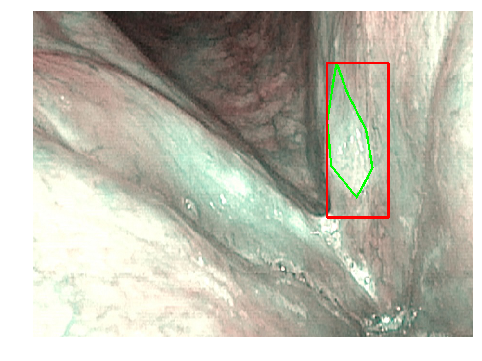

In [3]:
# ======================
# Data Exploration
# ======================
# We will use the results here to generalize for all images.
# We will create a bunch of utility functions for usage in later scripts.

CONTOUR_COLOR = (0,255,0)
BB_COLOR = (255,0,0)
PATCH_COLOR = (255,255,255)

k = test_contours_d[test_contours_d['uuid'] == 'b481bdcc-68c4-4724-a5fa-4f8fb6c6cd98'].iloc[0]
m = test_images_d[test_images_d['uuid'] == k['image_uuid']].iloc[0]
img_path = os.path.join(base_image_dir, m['filename'])
img = cv2.imread(img_path)
print(k)

kd = pd.read_csv(os.path.join(base_contours_dir, k['uuid'] + '.csv'))

def contours_csv_to_vector(d):
    v = np.array([d['x'], d['y']])
    return v.transpose()

def cvt_color(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def draw_label(img, v):
    return cv2.polylines(img,[v],True, CONTOUR_COLOR, 3)

def draw_rect(img, v):
    p1 = tuple(v[0])
    p3 = tuple(v[1])
    return cv2.rectangle(img, p1, p3, BB_COLOR, 3)
    
def show_img(img):
    plt.axis('off')
    plt.imshow(img)

def show_imgv(img, v):
    imgc = cvt_color(img)
    imgc = draw_label(imgc, v)
    show_img(imgc)

def show_imgb(img, bb):
    imgc = cvt_color(img)
    imgc = draw_rect(imgc, bb)
    show_img(imgc)
    
def show_imgvb(img, v, bb):
    imgc = cvt_color(img)
    imgc = draw_label(imgc, v)
    imgc = draw_rect(imgc, bb)
    show_img(imgc)
    
vals = contours_csv_to_vector(kd)
show_imgv(img.copy(), vals)

def create_bounding_box(img, v, patch_size = 64):
    h, w, _ = img.shape
    ps = patch_size
    x = v.T[0]
    y = v.T[1]
    x1 = np.min(x)
    x2 = np.max(x)
    y1 = np.min(y)
    y2 = np.max(y)
    
    xrange = x2 - x1
    yrange = y2 - y1
    
    xneeded = ps - (xrange % ps)
    yneeded = ps - (yrange % ps)
    
    if x2 + xneeded >= w:
        overlap = (x2 + xneeded) - w
        can_add = (xneeded - overlap)
        x2 += can_add
        x1 -= overlap
    else:
        x2 += xneeded
    
    if y2 + yneeded >= h:
        overlap = (y2 + yneeded) - h
        can_add = (yneeded - overlap)
        y2 += can_add
        y1 -= overlap
    else:
        y2 += yneeded
    
    assert(y2 <= h)
    assert(x2 <= w)
    
    # Note: sometimes a user may select a region that is the entire width or height of the image
    # if this is the case we could have created a bounding box larger than the underlying image
    # this means that we could have negative values for x1 or y1
    # If this is the case we will just scrink our bounding box by one patch_size in that dimension to accomodate
    
    if x1 < 0:
        xneg = np.abs(x1)
        x1 = 0
        x2 -= (ps - xneg)
    if y1 < 0:
        yneg = np.abs(y1)
        nps = int(yneg / ps)
        y1 = 0
        if nps == 0:
            y2 -= (ps - yneg)
        else:
            yneg -= (nps * ps)
            y2 -= (ps - yneg)
            
    
    assert((x2 - x1) % ps == 0)
    assert((y2 - y1) % ps == 0)
    
    box = np.array([[x1,y1],[x2,y2]])
    
    return box

def get_bounding_box_range(bb):
    xrange = bb[1][0] - bb[0][0]
    yrange = bb[1][1] - bb[0][1]
    return (xrange, yrange)

bb = create_bounding_box(img, vals)
show_imgvb(img.copy(), vals, bb)

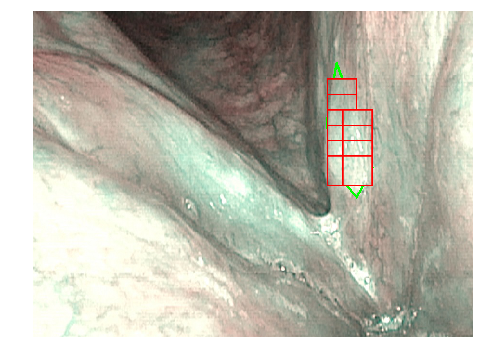

In [4]:
## Functions continued.
# Now we want to work on general purpose patch generation functions.
import math
import random
from shapely.geometry import Polygon


def show_patches(img, patches, points, patch_size = 64):
    ps = patch_size
    raw_img = cvt_color(img.copy())
    
    for i in range(len(patches)):
        p = cvt_color(patches[i])
        pi = points[i]
        
        # create a border
        bottom = top = int(0.05 * p.shape[0])  # shape[0] = rows
        right = left = int(0.05 * p.shape[1])  # shape[1] = cols
        dst = cv2.copyMakeBorder(p, top, bottom, left, right, cv2.BORDER_CONSTANT, None, (255,0,0))
        dst = cv2.resize(dst, (ps,ps))
        raw_img[(pi[1]):(pi[1]+ps), (pi[0]):(pi[0]+ps)] = dst
    show_img(raw_img)
    
def show_patches_v(img, patches, points, v, patch_size = 64):
    ps = patch_size
    
    show_patches(draw_label(img, v), patches, points, patch_size)

def generate_patches(img, bb, patch_size=64, patch_overlap=0.5):
    """
    This is a slow but full extraction method. It takes in an image and constructs all the patches
    of size :patch_size: which can be made from the given image.

    It assumes the patch size is square. Thus a patch_size of 32 will have the size 32x32 pixels.

    It returns a numpy array containing instances of Patch i.e. patches.
    """

    # img.shape returns the (rows,cols, Z)
    ps = patch_size
    po = patch_overlap
    
    xorig = bb[0][0]
    yorig = bb[0][1]
    
    crop_img = img[bb[0][1]:bb[1][1], bb[0][0]:bb[1][0]]
    show_img(cvt_color(crop_img))
    h, w, _ = crop_img.shape
    
    # ensure that our bounding box is correctly sized to fit the patch_size
    
    step = int(ps * po)
    
    assert(h % step == 0)
    assert(w % step == 0)
    
    rows = int(h / step)
    cols = int(w / step)
    
    points = []
    patches = []
    
    for j in range(rows):
        
        y = int(j * step)
        y2 = int(y + patch_size)
        
        for i in range(cols):
            x = int(i * step)
            x2 = int(x + patch_size)
            
            r = img[(yorig + y):(yorig + y2), (xorig + x):(xorig + x2)]

            # store a reference to the top left corner of the patch in the original image for later reference
            rp = np.array([xorig + x, yorig + y])

            # if the patch overlaps such that it is less than the patch size then drop it
            ry, rx, _ = r.shape
            if rx != ps or ry != ps:
                continue
            else:
                points.append(rp)
                patches.append(r)
    
    return (patches, points)

def filter_patches(patches, v, bb, points, threshold = 0.5):
    t = threshold
    p1 = Polygon(v)
    ps,_,_ = patches[0].shape
    filtered_patches = []
    filtered_points = []
    
    for idx in range(len(points)):
        p = points[idx]
        p2_raw = [p.tolist(), [p[0], p[1]+ps], [p[0]+ps, p[1]+ps], [p[0]+ps, p[1]]]
        p2 = Polygon(p2_raw)
        if not p2.intersects(p1):
            continue
        
        # NOTE: we must ensure polygons are valid
        # MATLAB appears to insert a point before the closing point of a polygon which is not part of the selected ROI
        # this creates invalid polygons i.e. self-intersecting polygons.
        # In order to catch this error we force both polygons to be valid
        # if they are not valid then we can look at the image, inspect its selected contours, and remove the violating point.
        
        assert(p2.is_valid)
        assert(p1.is_valid)
        
        iap = p2.intersection(p1).area / p2.area
        if iap >= t:
            filtered_points.append(p)
            filtered_patches.append(patches[idx])
    
    return filtered_patches, filtered_points
    
patches, points = generate_patches(img.copy(), bb)

filtered_patches, filtered_points = filter_patches(patches, vals, bb, points)
show_patches_v(img.copy(), filtered_patches, filtered_points, vals)

In [5]:
## Now we're ready to generate the patches over the entire image set
import shutil

def create_train_test_dirs(d):
    """
    Removes the train and test directories if they already exist.
    """
    train_dir = os.path.join(d, 'train')
    test_dir = os.path.join(d, 'test')
    
    if os.path.exists(train_dir):
        shutil.rmtree(train_dir)
    if os.path.exists(test_dir):
        shutil.rmtree(test_dir)
    
    os.makedirs(train_dir)
    os.makedirs(test_dir)
    return train_dir, test_dir

# store the train and test dirs so we can use them later
train_dir, test_dir = create_train_test_dirs(base_dir)
print(train_dir)
print(test_dir)

./data/38caa6a4/train
./data/38caa6a4/test


[0] uuid: b481bdcc-68c4-4724-a5fa-4f8fb6c6cd98, bbox: (128, 320), label: benign
[1] uuid: 85b520e4-cde2-477a-8ad1-502fdbca9a04, bbox: (320, 256), label: benign
[2] uuid: 057e89c2-cfec-47db-a299-864bcc6e4d0a, bbox: (192, 448), label: benign
[3] uuid: be67da6c-ec3c-4680-8015-26b434e63399, bbox: (320, 320), label: benign
[4] uuid: 87cfd4b1-b4eb-4c01-a1cc-ab9476a81652, bbox: (128, 128), label: papilloma
[5] uuid: b5ffa814-ad3c-4ce0-9067-7b7abb72f22f, bbox: (128, 64), label: papilloma
[6] uuid: 3ddbb745-ee35-4c0c-8ff9-346bf97f0a4a, bbox: (192, 256), label: papilloma
[7] uuid: d553a9f5-7e92-472b-bb83-13c01dd9b0b0, bbox: (192, 192), label: papilloma
[8] uuid: d09fba03-d2f6-4ff0-b993-610bdeeed21c, bbox: (128, 192), label: papilloma
[9] uuid: 5b38789c-afa2-4019-8a01-9220f1ca1878, bbox: (256, 320), label: carcinoma
[10] uuid: e92c2ad5-8d6b-4184-8baf-8a56c32783ec, bbox: (320, 512), label: dysplasia
[11] uuid: 83e6de39-64e8-4daf-aa32-df37f3ebc681, bbox: (256, 384), label: carcinoma
[12] uuid: 7b67

image_id                            contour_id  \
0  d7bdb01d-752a-4a8a-ab39-b01d4d5c163a  b481bdcc-68c4-4724-a5fa-4f8fb6c6cd98   
1  d7bdb01d-752a-4a8a-ab39-b01d4d5c163a  b481bdcc-68c4-4724-a5fa-4f8fb6c6cd98   
2  d7bdb01d-752a-4a8a-ab39-b01d4d5c163a  b481bdcc-68c4-4724-a5fa-4f8fb6c6cd98   
3  d7bdb01d-752a-4a8a-ab39-b01d4d5c163a  b481bdcc-68c4-4724-a5fa-4f8fb6c6cd98   
4  d7bdb01d-752a-4a8a-ab39-b01d4d5c163a  b481bdcc-68c4-4724-a5fa-4f8fb6c6cd98   

           patch_id             patch_name    x    y label_id  
0  R8uSzSMgQZwwXCdv  R8uSzSMgQZwwXCdv.jpeg  610  110        1  
1  LR6CKnBHB6mydXcS  LR6CKnBHB6mydXcS.jpeg  642  110        1  
2  UegkuiAQfkqZxEm3  UegkuiAQfkqZxEm3.jpeg  674  110        1  
3  RZjs3st3ScABqGco  RZjs3st3ScABqGco.jpeg  706  110        1  
4  HMcxttkYfTJ4798E  HMcxttkYfTJ4798E.jpeg  610  142        1

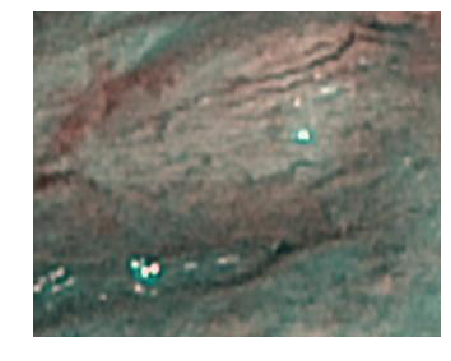

In [7]:
import shortuuid


def generate_patches_from_df(contours_df, images_df, contours_dir, images_dir, dest_dir, patch_size = 64, patch_overlap = 0.5, threshold = 0.5):
    
    out_df = pd.DataFrame(columns=['image_id', 'contour_id', 'patch_id', 'patch_name', 'x', 'y', 'label_id'])
    out_df_index = 0
    
    for index, k in contours_df.iterrows():
        
        # get the image
        image_uuid = k['image_uuid']
        target_img = images_df[images_df['uuid'] == image_uuid].iloc[0]
        target_img_path = os.path.join(images_dir, target_img['filename'])
        img = cv2.imread(target_img_path)
        
        # get the contour
        kdf = pd.read_csv(os.path.join(contours_dir, k['uuid'] + '.csv'))
        kv = contours_csv_to_vector(kdf)
        bb = create_bounding_box(img, kv, patch_size)
        
        print('[{}] uuid: {}, bbox: {}, label: {}'.format(index, k['uuid'], get_bounding_box_range(bb), k['target_class_label']))
        
        #show_imgvb(img, kv, bb)
        #plt.show()
    
        
        patches, points = generate_patches(img, bb, patch_size, patch_overlap)
        filtered_patches, filtered_points = filter_patches(patches, kv, bb, points, threshold)
        #show_patches_v(img, filtered_patches, filtered_points, kv)
        #plt.show()
        
        if not os.path.exists(dest_dir):
            raise Exception('destination directory: {} does not exist.'.format(dest_dir))
        
        # Now we have the patches, their locations in the image (points)
        # Its time to save them to a directory
        id_gen = shortuuid.ShortUUID()
        for idx in range(len(patches)):
            p = patches[idx]
            
            pt = points[idx]
            p_id = id_gen.random(length=16)
            p_img_name = p_id + '.jpeg'
            label_id = k['target_class_id']
            p_img_path = os.path.join(dest_dir, p_img_name)
            
            if os.path.exists(p_img_path):
                raise Exception('patch image already exist: {}'.format(p_img_path))
            
            # save image
            cv2.imwrite(p_img_path, p)
            
            # save data
            out_df.loc[out_df_index] = [image_uuid, k['uuid'], p_id, p_img_name, pt[0], pt[1], label_id]
            out_df_index += 1
    
    return out_df
            
            
# Generate the raw training data
#train_patches_df = generate_patches_from_df(train_contours_d, train_images_d, base_contours_dir, base_image_dir, train_dir)
#train_patches_df.to_csv(os.path.join(base_dir, 'train_patches.csv'))
#display(train_patches_df.head())

# Generate the raw testing data
#test_patches_df = generate_patches_from_df(test_contours_d, test_images_d, base_contours_dir, base_image_dir, test_dir)
#test_patches_df.to_csv(os.path.join(base_dir, 'test_patches.csv'))
#display(test_patches_df.head())

In [17]:
from importlib import reload
import libs.cleaning as cleaning

In [44]:
## Remove patches that are too specular and don't provide any good information
train_patches_df = pd.read_csv(os.path.join(base_dir, 'train_patches.csv'))
test_patches_df = pd.read_csv(os.path.join(base_dir, 'test_patches.csv'))
train_image_dir = os.path.join(base_dir, 'train')
test_image_dir = os.path.join(base_dir, 'test')

def remove_specular_patches(df, img_dir):
    white_img = cleaning.create_white_image((64,64,3))
    
    for idx, row in df.iterrows():
        patch_name = row['patch_name']
        img = cv2.imread(os.path.join(img_dir, patch_name))
        if cleaning.is_image_too_specular(img, white_img, threshold=0.5):
            df = df.drop(df.index[idx])
    return df
 


In [45]:
trbefore = len(train_patches_df)
train_patches_df = remove_specular_patches(train_patches_df, train_image_dir)
trafter = len(train_patches_df)
print('dropped {} train_patches due to specularity.'.format(trbefore - trafter))

tebefore = len(test_patches_df)
test_patches_df = remove_specular_patches(test_patches_df, test_image_dir)
teafter = len(test_patches_df)
print('dropped {} test_patches due to specularity.'.format(tebefore - teafter))

train_patches_df.to_csv(os.path.join(base_dir, 'train_patches.csv'))
test_patches_df.to_csv(os.path.join(base_dir, 'test_patches.csv'))


dropped 63 train_patches due to specularity.
dropped 21 test_patches due to specularity.
